# Process Mining with PM4Py: Inductive Miner Variants

This notebook demonstrates how to create different process models using various inductive miner implementations available in PM4Py. We'll use the filtered XES logs that were created during the preprocessing stage.

In [22]:
# Import required libraries
import os
import pm4py
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

# Set up the path to the data folder
data_folder = './data/filtered'

## 1. Helper Functions

Let's define some helper functions to load logs, discover models, visualize them, and evaluate their quality.

In [23]:
def load_log(log_file_path):
    """
    Load an XES log file
    
    Args:
        log_file_path: Path to the XES file
        
    Returns:
        PM4Py event log object
    """
    print(f"Loading log: {log_file_path}")
    log = xes_importer.apply(log_file_path)
    print(f"Log loaded with {len(log)} cases and {sum(len(case) for case in log)} events")
    return log

def discover_models(log, variant_name, variant):
    """
    Discover process models using the specified algorithm variant
    
    Args:
        log: PM4Py event log
        variant_name: String name of the variant (for display)
        variant: The actual algorithm variant to use
        
    Returns:
        Tuple containing process tree and Petri net with initial and final markings
    """
    print(f"\nDiscovering models using {variant_name}...")
    
    # Discover process tree
    process_tree = inductive_miner.apply(log, variant=variant)
    
    # Convert to Petri net for visualization and conformance checking
    net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
    
    return process_tree, net, initial_marking, final_marking

def visualize_models(process_tree, net, initial_marking, final_marking, variant_name, output_folder=None):
    """
    Visualize both process tree and Petri net models
    
    Args:
        process_tree: The process tree model
        net: The Petri net
        initial_marking: Initial marking for the Petri net
        final_marking: Final marking for the Petri net
        variant_name: String name of the variant (for display and filenames)
        output_folder: Folder to save visualizations (if None, just display)
    """
    # Visualize process tree
    pt_gviz = pt_visualizer.apply(process_tree)
    
    # Visualize Petri net
    parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
    pn_gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)

    # Display visualizations
    if output_folder:
        os.makedirs(output_folder, exist_ok=True)
        pt_visualizer.save(pt_gviz, os.path.join(output_folder, f"process_tree_{variant_name}.png"))
        pn_visualizer.save(pn_gviz, os.path.join(output_folder, f"petri_net_{variant_name}.png"))
        print(f"Visualizations saved to {output_folder} for {variant_name}")
    else:
        pt_visualizer.view(pt_gviz)
        pn_visualizer.view(pn_gviz)

def process_group(log, log_name, output_folder=None):
    """
    Process a log using different inductive miner variants
    
    Args:
        log: PM4Py event log object
        log_name: Name of the log file (without path)
        output_folder: Folder to save visualizations
    
    Returns:
        List of evaluation metrics for each variant
    """
    # If output folder is specified, create a subfolder for this log
    if output_folder:
        group_output_folder = os.path.join(output_folder, log_name.replace('.xes', ''))
        os.makedirs(group_output_folder, exist_ok=True)
    else:
        group_output_folder = None
    
    # List of variants to try
    variants = [
        ('IM', inductive_miner.Variants.IM),
        ('IMf', inductive_miner.Variants.IMf),
        ('IMd', inductive_miner.Variants.IMd)
    ]
    
    all_metrics = []
    
    # Process each variant
    for variant_name, variant in variants:
        # Discover models
        process_tree, net, initial_marking, final_marking = discover_models(log, variant_name, variant)
        
        # Visualize models
        visualize_models(process_tree, net, initial_marking, final_marking, variant_name, group_output_folder)
        
    return all_metrics



## 2. Analyze Each Group

Now let's process each filtered log in the data folder. We'll discover process models using different inductive miner variants for each group.

In [24]:
# Find all XES files in the data folder
xes_files = [f for f in os.listdir(data_folder) if f.endswith('.xes')]
print(f"Found {len(xes_files)} XES files in {data_folder}:")
for f in xes_files:
    print(f"  - {f}")

# Load all logs into memory once
logs = {}
for xes_file in xes_files:
    group_name = xes_file.replace('.xes', '').replace('group_', '')
    log_path = os.path.join(data_folder, xes_file)
    logs[group_name] = load_log(log_path)
    logs[xes_file] = logs[group_name]  # Also store with original filename as key for backwards compatibility
    
# Create a mapping from filename to group name for easier reference
file_to_group = {xes_file: xes_file.replace('.xes', '').replace('group_', '') for xes_file in xes_files}

Found 4 XES files in ./data/filtered:
  - group_consignment.xes
  - group_2_way.xes
  - group_3_way_after.xes
  - group_3_way_before.xes
Loading log: ./data/filtered/group_consignment.xes


parsing log, completed traces ::   0%|          | 0/11698 [00:00<?, ?it/s]

Log loaded with 11698 cases and 26953 events
Loading log: ./data/filtered/group_2_way.xes


parsing log, completed traces ::   0%|          | 0/289 [00:00<?, ?it/s]

Log loaded with 289 cases and 765 events
Loading log: ./data/filtered/group_3_way_after.xes


parsing log, completed traces ::   0%|          | 0/13035 [00:00<?, ?it/s]

Log loaded with 13035 cases and 282861 events
Loading log: ./data/filtered/group_3_way_before.xes


parsing log, completed traces ::   0%|          | 0/174845 [00:00<?, ?it/s]

Log loaded with 174845 cases and 954404 events


In [25]:
# Find all XES files in the data folder
xes_files = [f for f in os.listdir(data_folder) if f.endswith('.xes')]
print(f"Found {len(xes_files)} XES files in {data_folder}:")
for f in xes_files:
    print(f"  - {f}")

# Create output folder for visualizations
output_folder = './output'
os.makedirs(output_folder, exist_ok=True)

# Process each group using preloaded logs
all_results = {}
for xes_file in xes_files:
    print(f"\n{'='*50}")
    print(f"Processing {xes_file}")
    print(f"{'='*50}")
    group_metrics = process_group(logs[xes_file], xes_file, output_folder)
    all_results[xes_file] = group_metrics

Found 4 XES files in ./data/filtered:
  - group_consignment.xes
  - group_2_way.xes
  - group_3_way_after.xes
  - group_3_way_before.xes

Processing group_consignment.xes

Discovering models using IM...
Visualizations saved to ./output/group_consignment for IM

Discovering models using IMf...
Visualizations saved to ./output/group_consignment for IMf

Discovering models using IMd...
Visualizations saved to ./output/group_consignment for IMd

Processing group_2_way.xes

Discovering models using IM...
Visualizations saved to ./output/group_2_way for IM

Discovering models using IMf...
Visualizations saved to ./output/group_2_way for IMf

Discovering models using IMd...
Visualizations saved to ./output/group_2_way for IMd

Processing group_3_way_after.xes

Discovering models using IM...
Visualizations saved to ./output/group_3_way_after for IM

Discovering models using IMf...
Visualizations saved to ./output/group_3_way_after for IMf

Discovering models using IMd...
Visualizations saved t

## 2. Compliance Check per Classification

This analysis checks whether each purchase order case in the event log complies with the expected behavior defined by its item classification, based on the BPI Challenge 2019 documentation.

3-way match, invoice after GR:
The invoice is recorded after goods receipt, and both must exist in the trace (GR-based IV = true, Goods Receipt = true).

3-way match, invoice before GR:
The invoice can be recorded before goods receipt, but both events are still expected in the trace (GR-based IV = false, Goods Receipt = true).

2-way match:
Only an invoice is expected — no goods receipt is required (GR-based IV = false, Goods Receipt = false).

Consignment:
Goods are received but no invoice is expected or allowed (Goods Receipt = true, GR-based IV = false, and item type is consignment).

NOTE: We check event order based on the first occurrence of each activity in a case. This may miss edge cases with repeated events, but offers a practical balance between accuracy and simplicity.


Compliance Results:
consignment:
  ✅ Compliant: 11075 cases (94.67%)
  ❌ Non-compliant: 623 cases
  Total: 11698 cases
--------------------------------------------------
2_way:
  ✅ Compliant: 52 cases (17.99%)
  ❌ Non-compliant: 237 cases
  Total: 289 cases
--------------------------------------------------
3_way_after:
  ✅ Compliant: 9372 cases (71.90%)
  ❌ Non-compliant: 3663 cases
  Total: 13035 cases
--------------------------------------------------
3_way_before:
  ✅ Compliant: 12860 cases (7.36%)
  ❌ Non-compliant: 161985 cases
  Total: 174845 cases
--------------------------------------------------


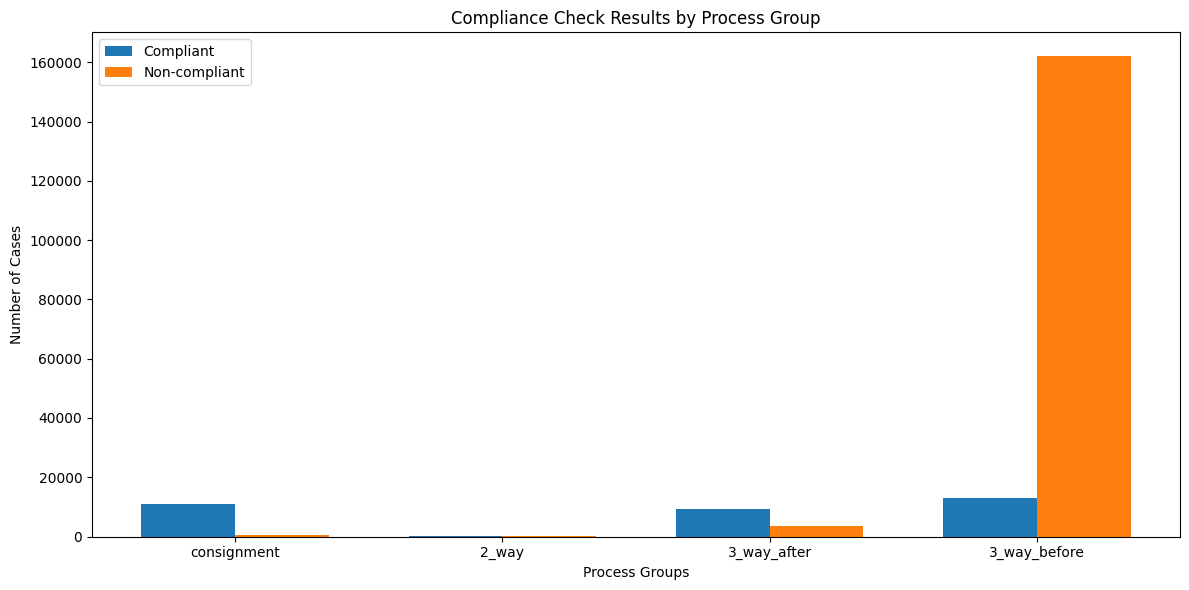

In [26]:
def check_case_compliance(log_files, preloaded_logs):
    """
    Check whether each filtered log complies with the expected behavior
    for its process group.

    Args:
        log_files: List of log file names in the filtered folder
        preloaded_logs: Dictionary of preloaded logs
    
    Returns:
        A dictionary containing counts of compliant and non-compliant cases per category.
    """
    # Initialize compliance results
    compliance_results = {}
    
    for log_file in log_files:
        # Extract group name from filename
        group_name = log_file.replace('.xes', '').replace('group_', '')
        
        # Use preloaded log
        log = preloaded_logs[log_file]
        
        # Initialize counters for this group
        compliant = 0
        non_compliant = 0
        
        # Check each case according to its group's specific rules
        for case in log:
            events = [e["concept:name"] for e in case]
            
            # 3-way match, invoice after goods receipt
            if "3_way_after" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" in events:
                    if events.index("Record Goods Receipt") < events.index("Record Invoice Receipt"):
                        compliant += 1
                    else:
                        non_compliant += 1  # wrong order
                else:
                    non_compliant += 1  # missing steps
            
            # 3-way match, invoice before goods receipt
            elif "3_way_before" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" in events:
                    if events.index("Record Invoice Receipt") < events.index("Record Goods Receipt"):
                        compliant += 1
                    else:
                        non_compliant += 1  # wrong order
                else:
                    non_compliant += 1  # missing steps
            
            # 2-way match
            elif "2_way" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" not in events:
                    compliant += 1
                else:
                    non_compliant += 1
            
            # Consignment
            elif "consignment" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" not in events:
                    compliant += 1
                else:
                    non_compliant += 1
        
        # Store results for this group
        compliance_results[group_name] = {
            "compliant": compliant,
            "non_compliant": non_compliant,
            "total": compliant + non_compliant,
            "compliance_rate": compliant / (compliant + non_compliant) * 100 if (compliant + non_compliant) > 0 else 0
        }
    
    return compliance_results

# Check compliance for all filtered logs using preloaded logs
compliance_results = check_case_compliance(xes_files, logs)

# Display results
print("\nCompliance Results:")
print("=" * 50)
for group, stats in compliance_results.items():
    print(f"{group}:")
    print(f"  ✅ Compliant: {stats['compliant']} cases ({stats['compliance_rate']:.2f}%)")
    print(f"  ❌ Non-compliant: {stats['non_compliant']} cases")
    print(f"  Total: {stats['total']} cases")
    print("-" * 50)

# Visualize results
plt.figure(figsize=(12, 6))
groups = list(compliance_results.keys())
compliant = [compliance_results[g]['compliant'] for g in groups]
non_compliant = [compliance_results[g]['non_compliant'] for g in groups]

x = range(len(groups))
width = 0.35

plt.bar(x, compliant, width, label='Compliant')
plt.bar([i + width for i in x], non_compliant, width, label='Non-compliant')

plt.xlabel('Process Groups')
plt.ylabel('Number of Cases')
plt.title('Compliance Check Results by Process Group')
plt.xticks([i + width/2 for i in x], groups)
plt.legend()

plt.tight_layout()
plt.show()


## 3. Compliance-based Model Discovery

Now that we have identified compliant and non-compliant cases in each process group, let's focus on the compliant cases to discover process models that represent the ideal behavior. We'll use these models later for conformance checking with all cases.

In [28]:
def filter_compliant_cases(log_files, preloaded_logs):
    """
    Filter logs to keep only compliant cases based on the process group rules.
    
    Args:
        log_files: List of log file names in the filtered folder
        preloaded_logs: Dictionary of preloaded logs
    
    Returns:
        Dictionary containing filtered logs with only compliant cases per group.
    """
    # Initialize filtered logs dictionary
    compliant_logs = {}
    
    for log_file in log_files:
        # Extract group name from filename
        group_name = log_file.replace('.xes', '').replace('group_', '')
        
        # Use preloaded log
        log = preloaded_logs[log_file]
        
        # Filter cases that comply with the group's rules
        compliant_cases = []
        
        for case in log:
            events = [e["concept:name"] for e in case]
            
            # 3-way match, invoice after goods receipt
            if "3_way_after" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" in events:
                    if events.index("Record Goods Receipt") < events.index("Record Invoice Receipt"):
                        compliant_cases.append(case)
            
            # 3-way match, invoice before goods receipt
            elif "3_way_before" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" in events:
                    if events.index("Record Invoice Receipt") < events.index("Record Goods Receipt"):
                        compliant_cases.append(case)
            
            # 2-way match
            elif "2_way" in log_file:
                if "Record Invoice Receipt" in events and "Record Goods Receipt" not in events:
                    compliant_cases.append(case)
            
            # Consignment
            elif "consignment" in log_file:
                if "Record Goods Receipt" in events and "Record Invoice Receipt" not in events:
                    compliant_cases.append(case)
        
        # Store filtered log if it contains cases
        if compliant_cases:
            compliant_logs[group_name] = pm4py.objects.log.obj.EventLog(compliant_cases)
            print(f"Filtered {group_name}: {len(compliant_cases)} compliant cases out of {len(log)} total cases")
        else:
            print(f"Warning: No compliant cases found for {group_name}")
    
    return compliant_logs

# Filter logs to keep only compliant cases
compliant_logs = filter_compliant_cases(xes_files, logs)

# Check if we have filtered logs for all groups
print("\nCompliant logs summary:")
for group, log in compliant_logs.items():
    print(f"{group}: {len(log)} cases with {sum(len(case) for case in log)} events")

Filtered consignment: 11075 compliant cases out of 11698 total cases
Filtered 2_way: 52 compliant cases out of 289 total cases
Filtered 3_way_after: 9372 compliant cases out of 13035 total cases
Filtered 3_way_before: 12860 compliant cases out of 174845 total cases

Compliant logs summary:
consignment: 11075 cases with 25879 events
2_way: 52 cases with 270 events
3_way_after: 9372 cases with 134180 events
3_way_before: 12860 cases with 84236 events


## 3.1 Abstracting Per-Item Activities

In procurement processes, many activities are performed at the item level (e.g., creating purchase order items). Let's create a framework for abstracting these per-item activities to focus on the high-level process flow.

In [36]:
import copy

def abstract_per_item_activities(log):
    """
    Abstract per-item activities in the log by grouping them into higher-level concepts.
    
    Args:
        log: PM4Py event log
        
    Returns:
        Abstracted PM4Py event log
    """
    # Create a copy of the log to avoid modifying the original
    abstracted_log = pm4py.objects.log.obj.EventLog()
    
    # Define per-item activities (can be extended as needed)
    per_item_activities = [
        "Create Purchase Order Item",
        "Record Goods Receipt",
        "Remove Payment Block",
        "Record Invoice Receipt",
        "Clear Invoice"
    ]
    
    # Define mapping to abstract activities (can be modified based on analysis)
    activity_mapping = {
        "Create Purchase Order Item": "Purchase Order Processing",
        "Record Goods Receipt": "Goods Receipt Processing",
        "Remove Payment Block": "Payment Processing",
        "Record Invoice Receipt": "Invoice Processing",
        "Clear Invoice": "Payment Processing"
    }
    
    # Process each case
    for case in log:
        # Create a new trace for the abstracted case
        abstracted_case = pm4py.objects.log.obj.Trace()
        
        # Copy case attributes
        for attr in case.attributes:
            abstracted_case.attributes[attr] = case.attributes[attr]
        
        # Prepare for abstraction
        current_abstractions = set()
        
        # Process each event
        for event in case:
            event_name = event["concept:name"]
            
            # Check if the event is a per-item activity
            if event_name in per_item_activities:
                # Map to abstract activity
                abstract_name = activity_mapping.get(event_name, event_name)
                
                # Add to abstracted case if not already added
                if abstract_name not in current_abstractions:
                    # Create new abstracted event
                    abstract_event = copy.deepcopy(event)
                    abstract_event["concept:name"] = abstract_name
                    abstract_event["abstracted"] = True

                    # Add event to case
                    abstracted_case.append(abstract_event)
                    current_abstractions.add(abstract_name)
            else:
                # Non per-item activity, keep as is
                abstracted_case.append(event)
        
        # Add abstracted case to log
        abstracted_log.append(abstracted_case)
    
    return abstracted_log

# Create abstracted versions of the compliant logs
abstracted_compliant_logs = {}
for group, log in compliant_logs.items():
    abstracted_compliant_logs[group] = abstract_per_item_activities(log)
    print(f"Abstracted {group}: {len(abstracted_compliant_logs[group])} cases")

# Basic comparison of original vs abstracted logs
print("\nActivity comparison (original vs abstracted):")
for group in compliant_logs.keys():
    orig_activities = set(pm4py.get_event_attribute_values(compliant_logs[group], "concept:name").keys())
    abst_activities = set(pm4py.get_event_attribute_values(abstracted_compliant_logs[group], "concept:name").keys())
    
    print(f"\n{group}:")
    print(f"  Original activities: {len(orig_activities)}")
    print(f"  Abstracted activities: {len(abst_activities)}")
    print(f"  Removed activities: {orig_activities - abst_activities}")
    print(f"  New abstract activities: {abst_activities - orig_activities}")

Abstracted consignment: 11075 cases
Abstracted 2_way: 52 cases
Abstracted 3_way_after: 9372 cases
Abstracted 3_way_before: 12860 cases

Activity comparison (original vs abstracted):

consignment:
  Original activities: 13
  Abstracted activities: 13
  Removed activities: {'Create Purchase Order Item', 'Record Goods Receipt'}
  New abstract activities: {'Goods Receipt Processing', 'Purchase Order Processing'}

2_way:
  Original activities: 5
  Abstracted activities: 5
  Removed activities: {'Create Purchase Order Item', 'Clear Invoice', 'Record Invoice Receipt'}
  New abstract activities: {'Invoice Processing', 'Payment Processing', 'Purchase Order Processing'}

3_way_after:
  Original activities: 30
  Abstracted activities: 29
  Removed activities: {'Remove Payment Block', 'Create Purchase Order Item', 'Clear Invoice', 'Record Invoice Receipt', 'Record Goods Receipt'}
  New abstract activities: {'Invoice Processing', 'Payment Processing', 'Goods Receipt Processing', 'Purchase Order Pro

## 3.2 Mining Compliance-based Process Models

Now let's discover process models from the compliant logs (both original and abstracted). These models represent the ideal process behavior.

In [37]:
# Output folder for compliance-based models
compliance_models_folder = os.path.join(output_folder, 'compliance_models')
os.makedirs(compliance_models_folder, exist_ok=True)

def discover_compliant_models(group_logs, output_folder, use_abstracted=False):
    """
    Discover process models from compliant logs
    
    Args:
        group_logs: Dictionary of filtered logs by group name
        output_folder: Folder to save visualizations
        use_abstracted: Whether to use abstracted logs
        
    Returns:
        Dictionary of discovered models per group
    """
    # Select the type of logs to use
    log_label = "abstracted" if use_abstracted else "original"
    print(f"\nDiscovering models from {log_label} compliant logs")
    
    # Dictionary to store discovered models
    discovered_models = {}
    
    for group_name, log in group_logs.items():
        print(f"\n{'-'*50}\nProcessing {group_name} ({log_label} compliant log)")
        
        # Create subfolder for this group
        group_folder = os.path.join(output_folder, f"{group_name}_{log_label}")
        os.makedirs(group_folder, exist_ok=True)
        
        # Discover process tree using IMf variant (good for filtering infrequent behavior)
        process_tree = inductive_miner.apply(log, variant=inductive_miner.Variants.IMf)
        
        # Convert to Petri net
        net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
        
        # Store models
        discovered_models[group_name] = {
            'process_tree': process_tree,
            'petri_net': (net, initial_marking, final_marking)
        }
        
        # Visualize process tree
        pt_gviz = pt_visualizer.apply(process_tree)
        pt_path = os.path.join(group_folder, f"process_tree.png")
        pt_visualizer.save(pt_gviz, pt_path)
        
        # Visualize Petri net
        parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
        pn_gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)
        pn_path = os.path.join(group_folder, f"petri_net.png")
        pn_visualizer.save(pn_gviz, pn_path)
        
        print(f"Models saved in {group_folder}")
        
    return discovered_models

# Discover models from original compliant logs
original_compliant_models = discover_compliant_models(compliant_logs, compliance_models_folder)

# Discover models from abstracted compliant logs
abstracted_compliant_models = discover_compliant_models(abstracted_compliant_logs, compliance_models_folder, use_abstracted=True)


Discovering models from original compliant logs

--------------------------------------------------
Processing consignment (original compliant log)
Models saved in ./output/compliance_models/consignment_original

--------------------------------------------------
Processing 2_way (original compliant log)
Models saved in ./output/compliance_models/2_way_original

--------------------------------------------------
Processing 3_way_after (original compliant log)
Models saved in ./output/compliance_models/3_way_after_original

--------------------------------------------------
Processing 3_way_before (original compliant log)
Models saved in ./output/compliance_models/3_way_before_original

Discovering models from abstracted compliant logs

--------------------------------------------------
Processing consignment (abstracted compliant log)
Models saved in ./output/compliance_models/consignment_abstracted

--------------------------------------------------
Processing 2_way (abstracted compl

## 4. Alignment-based Conformance Checking

Now let's perform alignment-based conformance checking to measure how well all cases (both compliant and non-compliant) align with our compliance-based process models. This will give us a more detailed view of the conformance issues in each group.

In [31]:
from pm4py.algo.conformance.alignments import algorithm as alignments
import numpy as np

def perform_alignments(models_dict, all_logs):
    """
    Perform alignment-based conformance checking between models and logs
    
    Args:
        models_dict: Dictionary of discovered models per group
        all_logs: Dictionary of all logs (including non-compliant cases)
        
    Returns:
        Dictionary with alignment results per group
    """
    alignment_results = {}
    
    for group_name, models in models_dict.items():
        print(f"\nPerforming alignments for {group_name}...")
        
        # Get the original log (all cases)
        if group_name in all_logs:
            full_log = all_logs[group_name]
        else:
            print(f"Warning: No log found for {group_name}, skipping.")
            continue
        
        # Get the Petri net model
        net, initial_marking, final_marking = models['petri_net']
        
        # Initialize alignment metrics
        case_fitness_values = []
        move_log_values = []
        move_model_values = []
        alignment_costs = []
        
        # Set parameters for alignment calculation
        parameters = {alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_TRACE_COST_FUNCTION: None}
        
        # Calculate alignments for each case
        print(f"  Processing {len(full_log)} cases...")
        
        # Use a sample of cases if the log is too large (for demonstration purposes)
        max_cases = min(len(full_log), 100)  # Adjust as needed
        sampled_log = full_log[:max_cases] if len(full_log) > max_cases else full_log
        
        # Perform alignment for each case
        for case_index, case in enumerate(sampled_log):
            if case_index % 10 == 0:
                print(f"  Processed {case_index}/{len(sampled_log)} cases")
                
            # Calculate alignment
            try:
                aligned_traces = alignments.apply(case, net, initial_marking, final_marking, parameters=parameters)
                
                # Extract metrics
                fitness = aligned_traces['fitness']
                case_fitness_values.append(fitness)
                
                # Count move types
                move_log = 0
                move_model = 0
                for step in aligned_traces['alignment']:
                    if step[0] == ">>" and step[1] != ">>":  # Model move
                        move_model += 1
                    elif step[0] != ">>" and step[1] == ">>":  # Log move
                        move_log += 1
                
                move_log_values.append(move_log)
                move_model_values.append(move_model)
                alignment_costs.append(aligned_traces['cost'])
                
            except Exception as e:
                print(f"  Error on case {case_index}: {str(e)}")
        
        # Compile results
        alignment_results[group_name] = {
            'case_fitness': case_fitness_values,
            'move_log': move_log_values,
            'move_model': move_model_values,
            'alignment_cost': alignment_costs,
            'average_fitness': np.mean(case_fitness_values) if case_fitness_values else 0,
            'median_fitness': np.median(case_fitness_values) if case_fitness_values else 0
        }
        
        print(f"  Alignment completed for {group_name}:")
        print(f"    Average fitness: {alignment_results[group_name]['average_fitness']:.4f}")
        print(f"    Median fitness: {alignment_results[group_name]['median_fitness']:.4f}")
    
    return alignment_results

# Perform alignments using original compliant models
print("\nPerforming alignments with original compliant models...")
original_alignment_results = perform_alignments(original_compliant_models, logs)

# Perform alignments using abstracted compliant models
print("\nPerforming alignments with abstracted compliant models...")
abstracted_alignment_results = perform_alignments(abstracted_compliant_models, abstracted_compliant_logs)

ImportError: cannot import name 'algorithm' from 'pm4py.algo.conformance.alignments' (/home/jaccobroeren/server/promAssignment/.venv/lib/python3.12/site-packages/pm4py/algo/conformance/alignments/__init__.py)

## 5. Visualizing Alignment Results

Let's visualize the alignment results to better understand the conformance issues in each process group.

In [ ]:
def visualize_alignment_results(alignment_results, title_prefix=""):
    """
    Create visualizations for alignment results
    
    Args:
        alignment_results: Dictionary with alignment results per group
        title_prefix: Prefix for plot titles
    """
    if not alignment_results:
        print("No alignment results to visualize.")
        return
    
    # Prepare data for boxplots
    fitness_data = []
    group_labels = []
    move_log_data = []
    move_model_data = []
    
    for group, results in alignment_results.items():
        if 'case_fitness' in results and results['case_fitness']:
            fitness_data.append(results['case_fitness'])
            group_labels.append(group)
            move_log_data.append(results['move_log'])
            move_model_data.append(results['move_model'])
    
    if not fitness_data:
        print("No fitness data to visualize.")
        return
    
    # Create boxplot for case fitness
    plt.figure(figsize=(12, 6))
    plt.boxplot(fitness_data, labels=group_labels)
    plt.title(f"{title_prefix}Case Fitness by Process Group")
    plt.ylabel("Fitness")
    plt.xlabel("Process Group")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create boxplot for log moves
    plt.figure(figsize=(12, 6))
    plt.boxplot(move_log_data, labels=group_labels)
    plt.title(f"{title_prefix}Log Moves by Process Group")
    plt.ylabel("Number of Log Moves")
    plt.xlabel("Process Group")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create boxplot for model moves
    plt.figure(figsize=(12, 6))
    plt.boxplot(move_model_data, labels=group_labels)
    plt.title(f"{title_prefix}Model Moves by Process Group")
    plt.ylabel("Number of Model Moves")
    plt.xlabel("Process Group")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create bar chart for average fitness
    avg_fitness = [results['average_fitness'] for results in alignment_results.values()]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(group_labels, avg_fitness)
    plt.title(f"{title_prefix}Average Fitness by Process Group")
    plt.ylabel("Average Fitness")
    plt.xlabel("Process Group")
    plt.ylim(0, 1.0)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Visualize results from original models
print("\nVisualization of alignment results with original compliant models:")
visualize_alignment_results(original_alignment_results, "Original Models - ")

# Visualize results from abstracted models
print("\nVisualization of alignment results with abstracted compliant models:")
visualize_alignment_results(abstracted_alignment_results, "Abstracted Models - ")

## 6. Detailed Analysis by Process Category

Now let's perform a more detailed analysis for each process category, focusing on the specific compliance issues and their root causes.

In [ ]:
def analyze_process_category(group_name, all_logs, alignment_results, compliance_results):
    """
    Perform detailed analysis for a specific process category
    
    Args:
        group_name: The name of the process group to analyze
        all_logs: Dictionary of all logs
        alignment_results: Alignment results dictionary
        compliance_results: Compliance results dictionary
    """
    print(f"\n{'='*70}")
    print(f"Detailed Analysis for Process Category: {group_name}")
    print(f"{'='*70}")
    
    # Basic statistics
    if group_name in all_logs:
        log = all_logs[group_name]
        variants = pm4py.get_variants(log)
        print(f"Total cases: {len(log)}")
        print(f"Total variants: {len(variants)}")
        print(f"Total events: {sum(len(case) for case in log)}")
        print(f"Average events per case: {sum(len(case) for case in log) / len(log):.2f}")
    else:
        print(f"No log data available for {group_name}")
        return
    
    # Compliance statistics
    if group_name in compliance_results:
        stats = compliance_results[group_name]
        print(f"\nCompliance Results:")
        print(f"  ✅ Compliant: {stats['compliant']} cases ({stats['compliance_rate']:.2f}%)")
        print(f"  ❌ Non-compliant: {stats['non_compliant']} cases")
    else:
        print(f"No compliance data available for {group_name}")
    
    # Alignment results
    if group_name in alignment_results:
        align_stats = alignment_results[group_name]
        
        print(f"\nAlignment Results:")
        print(f"  Average fitness: {align_stats['average_fitness']:.4f}")
        print(f"  Median fitness: {align_stats['median_fitness']:.4f}")
        print(f"  Average log moves: {np.mean(align_stats['move_log']):.2f}")
        print(f"  Average model moves: {np.mean(align_stats['move_model']):.2f}")
        
        # Distribution of fitness values
        plt.figure(figsize=(10, 5))
        plt.hist(align_stats['case_fitness'], bins=20, alpha=0.7)
        plt.title(f"Distribution of Case Fitness for {group_name}")
        plt.xlabel("Fitness")
        plt.ylabel("Number of Cases")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Scatter plot of log moves vs model moves
        plt.figure(figsize=(10, 5))
        plt.scatter(align_stats['move_log'], align_stats['move_model'], alpha=0.5)
        plt.title(f"Log Moves vs Model Moves for {group_name}")
        plt.xlabel("Log Moves")
        plt.ylabel("Model Moves")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No alignment data available for {group_name}")
    
    # Analyze specific compliance issues based on process category
    print(f"\nCommon Compliance Issues for {group_name}:")
    
    # Extract all events from the log
    all_events = []
    for case in log:
        case_events = [e["concept:name"] for e in case]
        all_events.extend(case_events)
    
    # Count event frequencies
    event_counts = {}
    for event in all_events:
        event_counts[event] = event_counts.get(event, 0) + 1
    
    # Sort events by frequency
    sorted_events = sorted(event_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Print top events
    print("\nTop 10 most frequent activities:")
    for event, count in sorted_events[:10]:
        print(f"  {event}: {count} occurrences")
    
    # Category-specific analysis
    if "3_way_after" in group_name.lower():
        print("\nSpecific Analysis for 3-way match (invoice after goods receipt):")
        analyze_event_order(log, "Record Goods Receipt", "Record Invoice Receipt", "correct order")
        
    elif "3_way_before" in group_name.lower():
        print("\nSpecific Analysis for 3-way match (invoice before goods receipt):")
        analyze_event_order(log, "Record Invoice Receipt", "Record Goods Receipt", "correct order")
        
    elif "2_way" in group_name.lower():
        print("\nSpecific Analysis for 2-way match:")
        # Check for cases with Goods Receipt (which shouldn't be there)
        gr_count = sum(1 for case in log if "Record Goods Receipt" in [e["concept:name"] for e in case])
        print(f"  Cases with Goods Receipt (violation): {gr_count} ({gr_count/len(log)*100:.2f}%)")
        
    elif "consignment" in group_name.lower():
        print("\nSpecific Analysis for Consignment:")
        # Check for cases with Invoice Receipt (which shouldn't be there)
        ir_count = sum(1 for case in log if "Record Invoice Receipt" in [e["concept:name"] for e in case])
        print(f"  Cases with Invoice Receipt (violation): {ir_count} ({ir_count/len(log)*100:.2f}%)")

def analyze_event_order(log, first_event, second_event, order_description):
    """
    Analyze the order of two events in a log
    
    Args:
        log: The event log
        first_event: The event that should come first
        second_event: The event that should come second
        order_description: Description of the correct order
    """
    # Count cases with both events
    both_events = sum(1 for case in log 
                      if first_event in [e["concept:name"] for e in case] 
                      and second_event in [e["concept:name"] for e in case])
    
    # Count cases with correct order
    correct_order = 0
    incorrect_order = 0
    
    for case in log:
        events = [e["concept:name"] for e in case]
        if first_event in events and second_event in events:
            if events.index(first_event) < events.index(second_event):
                correct_order += 1
            else:
                incorrect_order += 1
    
    # Report statistics
    print(f"  Cases with both {first_event} and {second_event}: {both_events} ({both_events/len(log)*100:.2f}%)")
    print(f"  Cases with {order_description}: {correct_order} ({correct_order/both_events*100:.2f}% of cases with both events)")
    print(f"  Cases with incorrect order: {incorrect_order} ({incorrect_order/both_events*100:.2f}% of cases with both events)")
    
    # Count cases missing either event
    missing_first = sum(1 for case in log if first_event not in [e["concept:name"] for e in case])
    missing_second = sum(1 for case in log if second_event not in [e["concept:name"] for e in case])
    
    print(f"  Cases missing {first_event}: {missing_first} ({missing_first/len(log)*100:.2f}%)")
    print(f"  Cases missing {second_event}: {missing_second} ({missing_second/len(log)*100:.2f}%)")

# Analyze each process category
process_categories = [cat for cat in compliance_results.keys()]

for category in process_categories:
    analyze_process_category(category, logs, original_alignment_results, compliance_results)

## 7. Conclusion

In this notebook, we have performed a comprehensive analysis of the procurement process using process mining techniques:

1. We started with filtering logs by process group and checking compliance with expected behavior
2. We discovered process models from compliant cases to establish the "ideal" process
3. We abstracted per-item activities to focus on the high-level process flow
4. We performed alignment-based conformance checking to measure how well cases align with the compliance-based models
5. We visualized alignment results using various metrics (fitness, log moves, model moves)
6. We conducted detailed analyses for each process category to identify specific compliance issues

Key findings:
- Different process groups have varying levels of compliance
- Abstracting per-item activities provides a clearer view of the high-level process
- Alignment-based conformance checking reveals more detailed conformance issues than simple fitness metrics
- Each process category has specific compliance challenges that can be addressed

Future work could include:
- Deeper analysis of specific compliance violations
- Root cause analysis of non-compliant behavior
- Process improvement recommendations
- Predictive models to identify potential compliance issues before they occur

## 3. Compare Results

Let's create a summary view to compare the performance of different inductive miner variants across the different process groups.

Empty DataFrame
Columns: []
Index: []


KeyError: 'log'

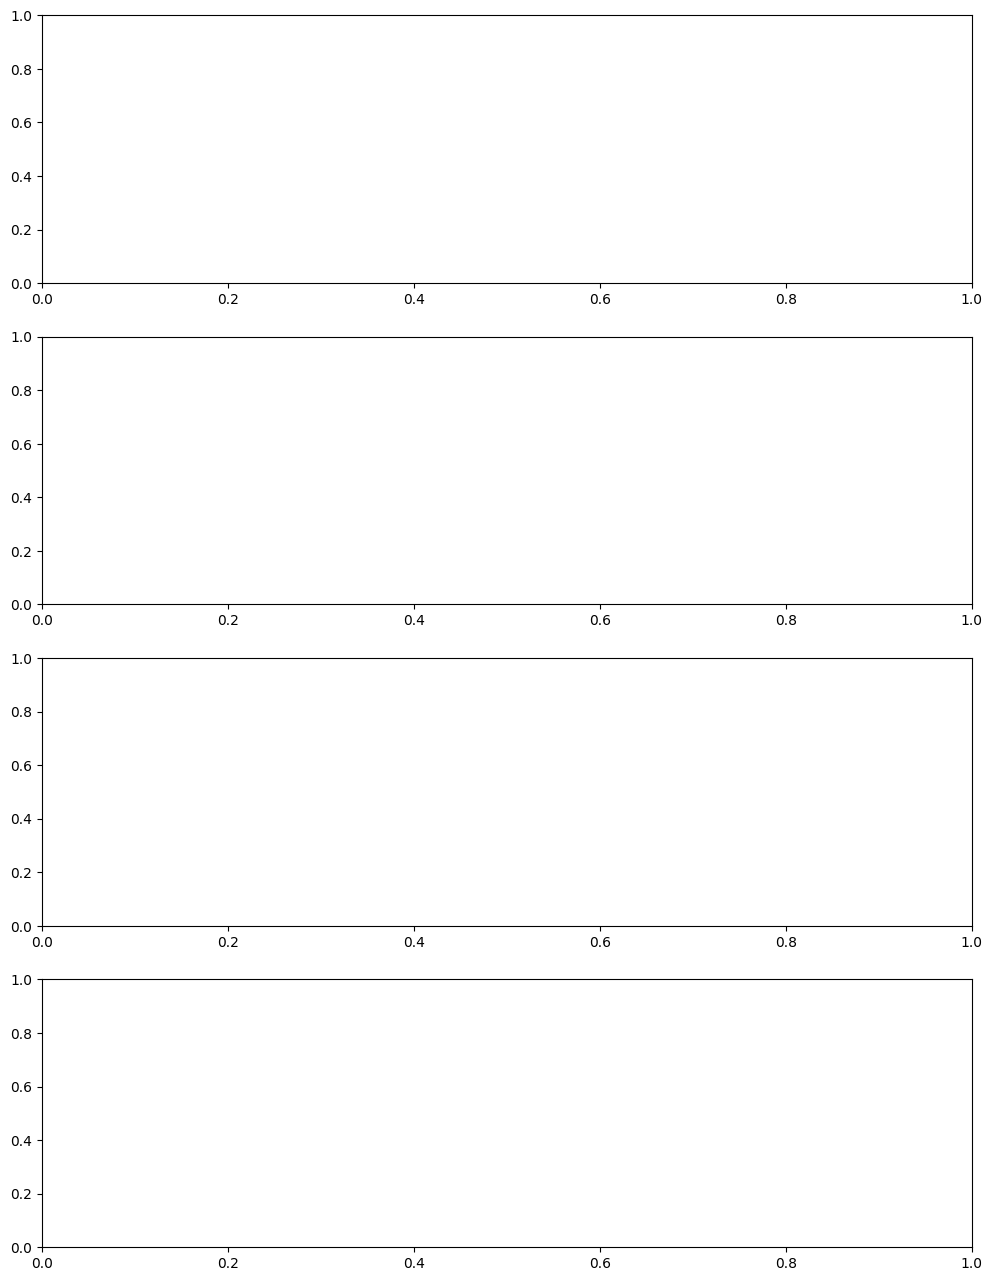

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe with all results
results_df = []
for log_name, metrics_list in all_results.items():
    for metrics in metrics_list:
        metrics_copy = metrics.copy()
        metrics_copy['log'] = log_name.replace('.xes', '').replace('group_', '')
        results_df.append(metrics_copy)

results_df = pd.DataFrame(results_df)
print(results_df)

# Plot the results using a heatmap for each metric
metrics = ['fitness', 'precision', 'generalization', 'simplicity']

fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4*len(metrics)))

for i, metric in enumerate(metrics):
    pivot_df = results_df.pivot(index='log', columns='variant', values=metric)
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', ax=axes[i])
    axes[i].set_title(f'{metric.capitalize()} by variant and log')

plt.tight_layout()
plt.show()

## 4. Detailed Analysis of the "2-way match" Process

Let's focus on the "2-way match" process group and analyze it in more detail.

In [ ]:
# Use the preloaded 2-way match log
two_way_log = logs['2_way']

# Get some basic statistics
print(f"Number of cases: {len(two_way_log)}")
print(f"Number of events: {sum(len(case) for case in two_way_log)}")
print(f"Average events per case: {sum(len(case) for case in two_way_log) / len(two_way_log):.2f}")

# Get the most frequent variants
variants = pm4py.get_variants(two_way_log)
print(f"Number of variants: {len(variants)}")

# Display top 5 variants
variant_count = [(count, trace) for trace, count in variants.items()]
variant_count.sort(reverse=True)
print("\nTop 5 variants:")
for i, (count, trace) in enumerate(variant_count[:5]):
    activities = [event['concept:name'] for event in trace]
    print(f"{i+1}. Count: {count} - Activities: {' → '.join(activities)}")

# Apply the IMf variant (usually good balance between precision and generalization)
process_tree = inductive_miner.apply_tree(two_way_log, variant=inductive_miner.Variants.IMF)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)

# Visualize the process tree and Petri net
pt_gviz = pt_visualizer.apply(process_tree)
pt_visualizer.view(pt_gviz)

# Perform more detailed conformance checking
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(two_way_log, net, initial_marking, final_marking)

# Analyze conformance results
conforming_traces = [trace for trace in replayed_traces if trace['trace_is_fit']]
print(f"Conforming traces: {len(conforming_traces)} out of {len(replayed_traces)} ({len(conforming_traces)/len(replayed_traces)*100:.2f}%)")

# Identify problematic transitions if any
all_transitions = set()
activated_transitions = set()
missing_transitions = set()

for trace in replayed_traces:
    for trans in trace['activated_transitions']:
        all_transitions.add(trans.name)
        activated_transitions.add(trans.name)
    for trans in trace['missing_tokens_transitions']:
        all_transitions.add(trans.name)
        missing_transitions.add(trans.name)

print("\nActivated transitions:", len(activated_transitions))
print("Missing transitions:", len(missing_transitions))
if missing_transitions:
    print("Problematic transitions:", missing_transitions)

## 5. Comparing Different Process Groups

Let's now compare the different process groups to understand how they differ from each other.

# Use the preloaded 2-way match log
two_way_log = logs['2_way']

# Get some basic statistics
print(f"Number of cases: {len(two_way_log)}")
print(f"Number of events: {sum(len(case) for case in two_way_log)}")
print(f"Average events per case: {sum(len(case) for case in two_way_log) / len(two_way_log):.2f}")

# Get the most frequent variants
variants = pm4py.get_variants(two_way_log)
print(f"Number of variants: {len(variants)}")

# Display top 5 variants
variant_count = [(count, trace) for trace, count in variants.items()]
variant_count.sort(reverse=True)
print("\nTop 5 variants:")
for i, (count, trace) in enumerate(variant_count[:5]):
    activities = [event['concept:name'] for event in trace]
    print(f"{i+1}. Count: {count} - Activities: {' → '.join(activities)}")

# Apply the IMf variant (usually good balance between precision and generalization)
process_tree = inductive_miner.apply_tree(two_way_log, variant=inductive_miner.Variants.IMF)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)

# Visualize the process tree and Petri net
pt_gviz = pt_visualizer.apply(process_tree)
pt_visualizer.view(pt_gviz)

# Perform more detailed conformance checking
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(two_way_log, net, initial_marking, final_marking)

# Analyze conformance results
conforming_traces = [trace for trace in replayed_traces if trace['trace_is_fit']]
print(f"Conforming traces: {len(conforming_traces)} out of {len(replayed_traces)} ({len(conforming_traces)/len(replayed_traces)*100:.2f}%)")

# Identify problematic transitions if any
all_transitions = set()
activated_transitions = set()
missing_transitions = set()

for trace in replayed_traces:
    for trans in trace['activated_transitions']:
        all_transitions.add(trans.name)
        activated_transitions.add(trans.name)
    for trans in trace['missing_tokens_transitions']:
        all_transitions.add(trans.name)
        missing_transitions.add(trans.name)

print("\nActivated transitions:", len(activated_transitions))
print("Missing transitions:", len(missing_transitions))
if missing_transitions:
    print("Problematic transitions:", missing_transitions)

In [ ]:
# Logs are already loaded, we can use them directly

# Compare number of variants and activities
for group_name, log in logs.items():
    variants = pm4py.get_variants(log)
    activities = pm4py.get_event_attribute_values(log, "concept:name")
    
    print(f"\nGroup: {group_name}")
    print(f"  Cases: {len(log)}")
    print(f"  Events: {sum(len(case) for case in log)}")
    print(f"  Variants: {len(variants)}")
    print(f"  Activities: {len(activities)}")
    print(f"  Events per case: {sum(len(case) for case in log) / len(log):.2f}")

# Identify common and unique activities across groups
all_activities = {}
for group_name, log in logs.items():
    activities = set(pm4py.get_event_attribute_values(log, "concept:name").keys())
    all_activities[group_name] = activities

# Find activities that appear in all groups
if len(all_activities) > 1:
    common_activities = set.intersection(*all_activities.values())
    print(f"\nCommon activities across all groups ({len(common_activities)}):")
    print(", ".join(sorted(common_activities)))
    
    # Find activities unique to each group
    for group_name, activities in all_activities.items():
        unique_activities = activities - set.union(*(set(acts) for g, acts in all_activities.items() if g != group_name))
        print(f"\nActivities unique to {group_name} ({len(unique_activities)}):")
        if unique_activities:
            print(", ".join(sorted(unique_activities)))
        else:
            print("None")

## 6. Advanced Process Mining: Directly-Follows Graphs

Let's visualize the directly-follows graphs (DFGs) for each process group, which can provide a simpler view of the process.

# Logs are already loaded, we can use them directly

# Compare number of variants and activities
for group_name, log in logs.items():
    # Skip entries with full filenames
    if group_name in xes_files:
        continue
        
    variants = pm4py.get_variants(log)
    activities = pm4py.get_event_attribute_values(log, "concept:name")
    
    print(f"\nGroup: {group_name}")
    print(f"  Cases: {len(log)}")
    print(f"  Events: {sum(len(case) for case in log)}")
    print(f"  Variants: {len(variants)}")
    print(f"  Activities: {len(activities)}")
    print(f"  Events per case: {sum(len(case) for case in log) / len(log):.2f}")

# Identify common and unique activities across groups
all_activities = {}
for group_name, log in logs.items():
    # Skip entries with full filenames
    if group_name in xes_files:
        continue
        
    activities = set(pm4py.get_event_attribute_values(log, "concept:name").keys())
    all_activities[group_name] = activities

# Find activities that appear in all groups
if len(all_activities) > 1:
    common_activities = set.intersection(*all_activities.values())
    print(f"\nCommon activities across all groups ({len(common_activities)}):")
    print(", ".join(sorted(common_activities)))
    
    # Find activities unique to each group
    for group_name, activities in all_activities.items():
        unique_activities = activities - set.union(*(set(acts) for g, acts in all_activities.items() if g != group_name))
        print(f"\nActivities unique to {group_name} ({len(unique_activities)}):")
        if unique_activities:
            print(", ".join(sorted(unique_activities)))
        else:
            print("None")

In [ ]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# For each log, create and visualize a directly-follows graph
for group_name, log in logs.items():
    # Skip entries with full filenames
    if group_name in xes_files:
        continue
        
    print(f"\nGenerating DFG for {group_name}...")
    
    # Discover directly-follows graph
    dfg, start_activities, end_activities = pm4py.discover_directly_follows_graph(log)
    
    # Visualize DFG
    parameters = {dfg_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
    gviz = dfg_visualizer.apply(dfg, start_activities, end_activities, parameters=parameters)
    
    # Save to file
    output_path = os.path.join(output_folder, f"dfg_{group_name}.png")
    dfg_visualizer.save(gviz, output_path)
    
    print(f"DFG visualization saved to {output_path}")
    
    # Just for display in the notebook
    dfg_visualizer.view(gviz)

    # Also generate a performance DFG to show time differences
    perf_dfg, perf_sa, perf_ea = pm4py.discover_performance_directly_follows_graph(log)
    
    # Visualize performance DFG
    perf_gviz = dfg_visualizer.apply(perf_dfg, perf_sa, perf_ea, variant=dfg_visualizer.Variants.PERFORMANCE, 
                                 parameters=parameters)
    
    # Save to file
    perf_output_path = os.path.join(output_folder, f"perf_dfg_{group_name}.png")
    dfg_visualizer.save(perf_gviz, perf_output_path)
    
    print(f"Performance DFG visualization saved to {perf_output_path}")
    
    # Just for display in the notebook
    dfg_visualizer.view(perf_gviz)

## 12. Overall Conclusion

In this notebook, we have:

1. Loaded and analyzed filtered XES logs for different process groups
2. Used various inductive miner variants to discover process models
3. Evaluated the quality of these models using standard metrics
4. Filtered cases based on compliance and created compliant models
5. Performed alignment-based conformance checking
6. Abstracted per-item activities
7. Compared different process groups
8. Visualized models as process trees, Petri nets, and directly-follows graphs

The different inductive miner variants offer different trade-offs:
- IM (Inductive Miner): Balanced approach, guarantees sound models
- IMf (Inductive Miner - infrequent): Filters out infrequent behavior
- IMd (Inductive Miner - directly follows): Uses the directly-follows abstraction
- IM_CLEAN: More aggressive filtering approach to create simpler models

We've also evaluated how well cases align with the compliance-based models, which can provide valuable insights for process improvement.

For further analysis, you might consider:
- Even deeper analysis of specific compliance violations
- Resource perspective analysis (who performs which activities)
- Time perspective analysis (bottlenecks, throughput times)
- Building predictive models based on these discovered processes and compliance patterns